In [1]:
import pandas as pd
import numpy as np
import os
import json

In [2]:
import sklearn
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import IsolationForest

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

sns.set(style="darkgrid")
plt.style.use('bmh')
plt.rcParams['figure.figsize'] = 9, 4

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
from codes.plotting_funcs import plot_features_dists, plot_boxplots
from codes.iqrs import medcouple
from codes.iqrs import iqr_segment

In [6]:
from tqdm.notebook import tqdm
from IPython.display import display
pd.options.display.max_columns = 100

In [7]:
SEED = 10

# Препроцессинг: обработка пропусков и выбросов

В прошлом ноутбуке была проведена частичная обработка признаков. В этом -- комплексные преобразования.

In [8]:
df_train = pd.read_csv('new_data/df.csv')
df_test = pd.read_csv('new_data/df_test.csv')
with open('features_types.json') as features_types_file:
    features_types = json.load(features_types_file)
    
floats = set(features_types['float'])
ints = set(features_types['int'])
binary = set(features_types['binary'])
cats = set(features_types['categorical'])
    
df_train.shape

(78744, 81)

# Обработка пропусков в данных

Теперь нужно обработать пропуски в данных. До этого пропуски обрабатывались в частном порядке.

Для начала посчитаем среднее число пропусков в каждом столбце в процентном соотношении.

In [9]:
nandf = df_train.isnull()
nans = pd.DataFrame(nandf.mean(axis=0) * 100, columns=['quantity'])
nans['types'] = df_train.dtypes
inds = nans[nans.quantity == 0].index
nans.drop(index=inds, inplace=True)
len(nans)

43

Выведем признаки, в которых доля пропусков больше 30%.

In [10]:
nans[nans.quantity > 30.0]

,quantity,types
lor,30.219445,float64
numbcars,49.352332,float64
ownrent,33.673677,object
dwlltype,31.891954,object
HHstatin,37.926699,object
dwllsize,38.274662,object


Признак `numbcars` практически наполовину пуст. Его можно удалить, если пользователь не указывал информации о своих автомобилях, или заполнить нулями, если мы считаем, что если информации нет, то машин у пользователя не имеется. Выберем второй вариант, так как он кажется более разумным.

In [11]:
df_train.numbcars.fillna(0, inplace=True)
df_test.numbcars.fillna(0, inplace=True)
del nans, inds, nandf

Сложно предполагать, что означают остальные признаки. В отсутствии предположений будем заполнять пропуски единым способом.

## Заполнение пропусков числовых и бинарных признаков

Числовые признаки зачастую заполняются средним значением (или медианой). В этом случае статистики сохраняются, однако теряется информация о пропуске в данных, что может быть важно. Можно ввести дополнительные индикаторные признаки, которые будут говорить о том, был ли пропуск в соответствующем столбце. Тогда регрессионная модель будет иметь вид:

$$\ldots + w_n x_n + w_{n+1} I_{пропуск\ в\ x_n}(x_n) + \ldots$$

Такой подход позволяет весам $w_n$ и $w_{n+1}$ корректировать друг друга, тем самым модель может выучить оптимальный вес для пропусков.

Отметим, что бывают случаи, когда заполнять пропуски средним нельзя. Например, если в какой-то компании 995 сотрудников с зарплатой 50 000 и 5 сотрудников с зарплатой в 5 000 000, то средняя зарплата составляет 74 7500. В этом случае лучше заполнять пропуски медианой, так как по сути в этой выборке есть 5 выбросов.

Я также отмечаю, что в распределениях числовых признаков есть столбец нулей. Сложно сказать, почему так и как с этим работать. Может быть, часть пользователей не указывала какие-то данные (при анкетировании такое может быть), либо же часть выборки бралась из данных, где изначально не было этих столбцов, а может быть, что такие данные напрямую отображают действительность, и нулевое значение является важным.

Давайте посмотрим на то, что будет с распределением, если мы заменим нули, например, средним без учета нулевых значений (в этом случае можно было бы добавить столбец-индикатор).

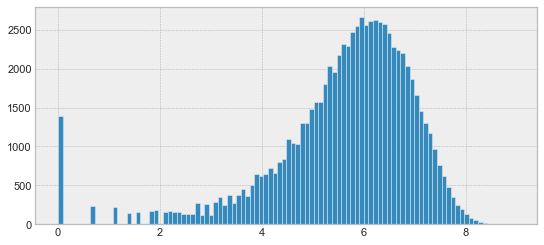

In [12]:
# полное распределение
_ = df_train.log1p_avg3mou.hist(bins=100)

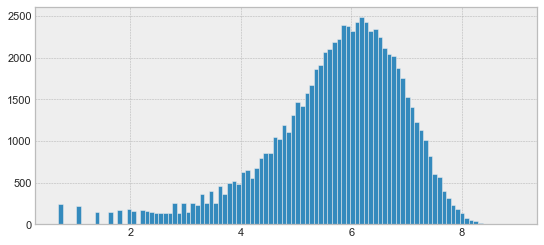

In [13]:
# Распределение без нулей
_ = df_train[df_train.log1p_avg3mou != 0].log1p_avg3mou.hist(bins=100)

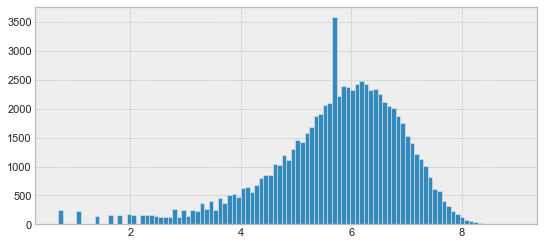

In [14]:
# распределение с заполненными средним пропусками
vals = df_train.log1p_avg3mou.values.copy()
inds = df_train[df_train.log1p_avg3mou == 0].index
vals[inds] = df_train[df_train.log1p_avg3mou != 0].log1p_avg3mou.mean()
_ = plt.hist(vals, bins=100)

In [15]:
del vals

Идея кажется не очень здравой: намного выгоднее кажется просто удалить эти строки. Насколько же это оправдано?

In [16]:
df_train[df_train.log1p_avg3mou == 0].head()

,log1p_ovrrev_Mean,log1p_inonemin_Mean,log1p_callwait_Mean,log1p_owylis_vce_Mean,log1p_unan_vce_Mean,log1p_ovrmou_Mean,log1p_attempt_Mean,log1p_da_Mean,log1p_mouiwylisv_Mean,log1p_recv_vce_Mean,log1p_mou_rvce_Mean,log1p_mou_cvce_Mean,log1p_comp_dat_Mean,log1p_vceovr_Mean,log1p_mouowylisv_Mean,log1p_drop_vce_Mean,log1p_mou_Mean,log1p_totmrc_Mean,log1p_blck_vce_Mean,log1p_iwylis_vce_Mean,log1p_mou_opkv_Mean,log1p_drop_blk_Mean,log1p_mou_cdat_Mean,log1p_rev_Mean,log1p_ccrndmou_Mean,log1p_threeway_Mean,log1p_custcare_Mean,log1p_mou_peav_Mean,log1p_datovr_Mean,log1p_roam_Mean,log1p_opk_vce_Mean,change_mou,change_rev,log1p_totcalls,log1p_avg3mou,log1p_avg3qty,log1p_avg3rev,log1p_adjqty,log1p_avg36mou_abs_diff,log1p_avg36rev_abs_diff,log1p_avg36qty_abs_diff,log1p_adjrev,log1p_adjmou,log1p_avgrev,log1p_avgqty,months,uniqsubs,actvsubs,phones,models,lor,adults,numbcars,eqpdays,hnd_price,kid16_17,refurb_new,ownrent,rv,dwlltype,truck,creditcd,kid3_5,infobase,kid6_10,forgntvl,kid0_2,asl_flag,kid11_15,new_cell,ethnic,crclscod,HHstatin,marital,hnd_webcap,dwllsize,area,prizm_social_one,dualband,income,churn
67,0.0,0.0,0.0,0.0,0.287682,0.0,0.287682,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.772589,0.0,0.0,0.0,0.0,0.0,2.780991,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.1350,4.248495,0.0,0.0,2.772589,4.174387,1.098612,0.000000,1.098612,5.722931,5.105945,2.835564,1.474763,22.0,1.0,1.0,1.0,1.0,NaN,NaN,0.0,660.0,10.0,U,R,NaN,0.0,NaN,0.0,N,U,NaN,U,0.0,U,N,U,U,J,A,NaN,U,WC,NaN,DC/MARYLAND/VIRGINIA AREA,S,Y,NaN,1
201,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.397895,0.0,0.0,0.0,0.0,0.0,2.397895,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,5.225747,0.0,0.0,2.397895,4.919981,2.639057,0.000000,1.386294,4.518740,6.720220,2.405142,2.779440,11.0,2.0,2.0,1.0,1.0,3.0,1.0,2.0,330.0,80.0,U,N,O,0.0,S,0.0,Y,U,M,U,0.0,U,N,U,U,I,AA,C,M,WCMB,A,CHICAGO AREA,S,Y,8.0,1
202,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.397895,0.0,0.0,0.0,0.0,0.0,2.397895,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,8.200288,0.0,0.0,2.397895,8.200288,2.639057,1.098612,1.791759,8.010881,9.341908,4.057681,4.244200,54.0,1.0,1.0,1.0,1.0,10.0,2.0,0.0,1636.0,30.0,U,N,O,0.0,NaN,0.0,Y,U,M,U,0.0,U,N,U,N,N,A,I,A,NaN,NaN,NORTHWEST/ROCKY MOUNTAIN AREA,C,N,3.0,1
280,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.674321,0.0,0.0,0.0,0.0,0.0,2.175036,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-8.8925,7.518064,0.0,0.0,2.484907,7.331060,0.000000,1.791759,0.000000,6.328419,8.014997,4.145354,5.139087,10.0,3.0,3.0,1.0,1.0,15.0,3.0,2.0,297.0,100.0,U,N,O,0.0,S,0.0,Y,U,M,Y,0.0,U,N,Y,U,Z,BA,H,M,WCMB,A,HOUSTON AREA,NaN,T,6.0,1
312,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.433665,0.0,0.0,0.0,0.0,0.0,3.044046,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,8.023225,0.0,0.0,3.044522,8.023225,0.000000,0.000000,0.000000,7.720337,9.279866,4.099000,4.397654,39.0,1.0,1.0,2.0,2.0,1.0,NaN,0.0,340.0,60.0,U,N,O,0.0,S,0.0,N,U,M,U,0.0,U,N,U,U,N,A,NaN,U,WCMB,NaN,SOUTH FLORIDA AREA,NaN,Y,NaN,1


Довольно много числовых признаков занулено, однако категориальные непусты. Может, тогда стоит удалять такие признаки? Посмотрим уже не на пропущенные значения, а на нулевые.

In [17]:
# только для непрерывных признаков
df_nulls = (df_train[floats] == 0.0).astype(int)
nulls = pd.DataFrame(df_nulls.mean() * 100, columns=['%'])
nulls.sort_values(by='%', ascending=False, inplace=True)
nulls.head(20)

,%
log1p_mou_cdat_Mean,86.757086
log1p_comp_dat_Mean,86.757086
log1p_datovr_Mean,86.194504
log1p_threeway_Mean,73.680534
log1p_roam_Mean,68.939856
log1p_custcare_Mean,56.027126
log1p_ccrndmou_Mean,56.027126
log1p_callwait_Mean,50.073656
log1p_da_Mean,48.658945
log1p_vceovr_Mean,47.735700


Есть столбцы, которые очень сильно заполнены нулями. Такие столбцы, безусловно, неинформативны и подлежат удалению. Удалим те признаки, доля нулей в которых свыше 50%.

In [18]:
todel = nulls[nulls['%'] > 50].index.tolist()
todel

['log1p_mou_cdat_Mean',
 'log1p_comp_dat_Mean',
 'log1p_datovr_Mean',
 'log1p_threeway_Mean',
 'log1p_roam_Mean',
 'log1p_custcare_Mean',
 'log1p_ccrndmou_Mean',
 'log1p_callwait_Mean']

In [19]:
df_train.drop(columns=todel, inplace=True)
df_test.drop(columns=todel, inplace=True)
floats -= set(todel)
del df_nulls, nulls, todel

Что касаемо оставшихся признаков -- их стоит оставить. С нулями ничего делать не будем: они все равно не повлияют на предикты (нулевой вес в регрессии). Заполним все **медианой**, так как имеются некоторые выбросы. К слову, целочисленные признаки заполнятся целым числом.

In [20]:
dfs = {'train': df_train, 'test': df_test}

In [21]:
indicators = set({})

def process_nan(dfs: dict, features: list, imputer: sklearn.impute.SimpleImputer, num=False, na_inds=indicators):
    for name in features:
        imputer = imputer.fit(dfs['train'][name].values.reshape(-1,1))
        
        for key in dfs:
            dfs[key][name] = imputer.transform(dfs[key][name].values.reshape(-1,1))
            if num:
                # добавляем столбец-индикатор
                dfs[key][name + '_ind'] = dfs[key][name].isnull().astype(int)
                na_inds |= set([name + '_ind'])

In [22]:
imputer_num = SimpleImputer(missing_values=np.nan, strategy='median')
process_nan(dfs, ints | floats, imputer_num, num=True)
df_train.shape

(78744, 120)

In [23]:
floats

{'change_mou',
 'change_rev',
 'log1p_adjmou',
 'log1p_adjqty',
 'log1p_adjrev',
 'log1p_attempt_Mean',
 'log1p_avg36mou_abs_diff',
 'log1p_avg36qty_abs_diff',
 'log1p_avg36rev_abs_diff',
 'log1p_avg3mou',
 'log1p_avg3qty',
 'log1p_avg3rev',
 'log1p_avgqty',
 'log1p_avgrev',
 'log1p_blck_vce_Mean',
 'log1p_da_Mean',
 'log1p_drop_blk_Mean',
 'log1p_drop_vce_Mean',
 'log1p_inonemin_Mean',
 'log1p_iwylis_vce_Mean',
 'log1p_mou_Mean',
 'log1p_mou_cvce_Mean',
 'log1p_mou_opkv_Mean',
 'log1p_mou_peav_Mean',
 'log1p_mou_rvce_Mean',
 'log1p_mouiwylisv_Mean',
 'log1p_mouowylisv_Mean',
 'log1p_opk_vce_Mean',
 'log1p_ovrmou_Mean',
 'log1p_ovrrev_Mean',
 'log1p_owylis_vce_Mean',
 'log1p_recv_vce_Mean',
 'log1p_rev_Mean',
 'log1p_totcalls',
 'log1p_totmrc_Mean',
 'log1p_unan_vce_Mean',
 'log1p_vceovr_Mean'}

Бинарные признаки закодируем через `LabelEncoder` лишь для того, чтобы просто заполнить их медианой. Я делаю так только потому, что мне не придется расшифровывать категории в EDA в силу отсутствия информации о данных.

In [24]:
for binar in binary:
    encoder = LabelEncoder().fit(df_train[binar])
    for key in dfs:
        dfs[key][binar] = encoder.transform(dfs[key][binar])

In [25]:
imputer_num = SimpleImputer(missing_values=np.nan, strategy='median')
process_nan(dfs, binary, imputer_num)

In [26]:
for col in ints | binary:
    for key in dfs:
        dfs[key][col] = dfs[key][col].astype(int)

## Заполнение пропусков категориальных признаков

Категориальные пропуски обычно заполняются либо категорией, которая обозначает пропуск, либо же наиболее часто встречаемым значением. Я выбираю первый вариант, так как хотел бы сохранить информацию о пропуске.

In [27]:
for key in dfs:
    dfs[key][list(cats)] = dfs[key][cats].fillna('UNK')

In [28]:
df_train[cats].head()

,ethnic,dualband,area,hnd_webcap,new_cell,marital,crclscod,dwllsize,HHstatin,income,prizm_social_one
0,N,Y,CHICAGO AREA,WCMB,Y,M,AA,A,I,6.0,S
1,N,N,SOUTHWEST AREA,UNK,U,U,AA,UNK,UNK,UNK,R
2,J,Y,GREAT LAKES AREA,WCMB,U,M,AA,A,I,6.0,R
3,P,Y,CHICAGO AREA,WCMB,U,U,DA,UNK,UNK,UNK,C
4,Z,N,NEW YORK CITY AREA,WC,U,U,AA,UNK,UNK,UNK,U


Посмотрим, все ли пропуски мы заполнили.

In [29]:
assert df_train.isnull().sum().sum() == 0
assert df_test.isnull().sum().sum() == 0

In [30]:
del dfs

# Детекция выбросов

Конечно же, выбросы могут появляться и в тестовой выборке, поэтому их удаление из обучающей выборки может привести к ухудшению качества. И все же стоит удалять выбросы из обучения в силу улучшения интерпретируемости модели.

Я буду удалять выбросы сначала с помощью одномерного (статистического) подхода и многомерного (модельного).

## Статистический подход

Иногда возникает вопрос о том, что считать выбросом. Например, в предудыщем ноутбуке есть признаки `uniqsubs` и `actvsubs` -- число подписчиков (или подписок), и встречаются объекты с высокими значениями этих показателей. В действительности такие пользователи есть в социальной сети, и было бы несколько иррационально считать такие значения выбросами (если они не слишком экстремальны). Однако особую роль играет тот момент, что такие значения не вписываются в распределение (как можно было заметить на графиках), таких пользователей мало, и на руку это не играет.

Поэтому выбросами я буду считать те объекты, которые выходят за рамки некоторого интервала (отрезка), а именно -- интерквантильного размаха.

*Интерквантильным размахом называется величина, равная разности между 3 и 1 квантилями, т.е.* 

$$IQR = Q_3 - Q_1$$

Тогда выбросом считается значение за границами отрезка $[Q_1 - \frac{3}{2}IQR; Q_3 + \frac{3}{2}IQR]$. Статистически метод восходит к *правилу трех сигм* нормального распределения и является его некоторым робастным аналогом ([информация](https://github.com/pileyan/Isolation_trees/blob/main/outliers.ipynb)). Из этого возникает несколько проблем.

Первая проблема может заключаться в том, что отрезок симметричный, а значит, что у неблизких к нормальному распределений (несимметричных) часть выбросов может попасть в этот интервал, что, безусловно, плохо. 

Другая проблема -- часто в распределениях с тяжелыми хвостами часть данных рассматривается как выбросы, что влечет за собой потерю информации и недо- или переобучение как следствие.

В поиске ответа на этот вопрос я наткнулся на следущую [статью](https://www.sciencedirect.com/science/article/abs/pii/S0167947307004434). В ней описывается метод, который позволяет учитывать несимметричность, тем самым подстраивая интервантильный отрезок под распределение. *(Некоторая информация из статьи спрятана в этой ячейке в комментариях).*

<!-- Вводится коэффициент `medcouple` ($MC$), который выступает в роли меры ассиметрии распределения `F`:

$$MC(F) = \underset{x_1 < m_F < x_2}{\text{median}} h(x_1, x_2),$$

где $h(x_i, x_j) = \frac{(x_i - m_F) - (m_F - x_j)}{x_i - x_j}$.

$MC$ лежит в промежутке от -1 до 1 в зависимости от смещенности распределения, и равен нулю, если оно симметричное. Используя этот коэффициент, можно внести простую вариацию в отрезок:

$$[Q_1 - h_l(MC) IQR; Q_3 + h_r(MC) IQR],$$

где $h_l(MC), h_r(MC),\ s.t.\ h_l(0) = h_r(0) = 1.5$ -- некоторые функции, позволяющие менять части отрезков на основе смещения распределения для отделения выбросов. Так, для экспоненциального распределения этот отрезок будет иметь более длинную правую часть и более короткую левую, тем самым выбросы справа будут отделяться лучше.

Принцип определения этих функций основан на "ожидаемом проценте отмеченных выбросов" в 0.7%, что и регламентирует $IQR$ при нормальным распределении. -->

Большинство признаков приближено к нормальному распределению, но имеются и некоторые, которые близки к распределению Фишера или экспоненциальному. Для отлова выбросов таких распределений авторы статьи вывели формулу (для смещения вправо):

$$[Q_1 - 1.5e^{-3.5MC}IQR; Q_3 + 1.5e^{4MC}IQR]$$

Аналогично, для смещения влево:

$$[Q_1 - 1.5e^{4MC}IQR; Q_3 + 1.5e^{-3.5MC}IQR]$$

Посмотрим, как выглядят боксплоты и распределения признаков с выбросами и без них после очистки.

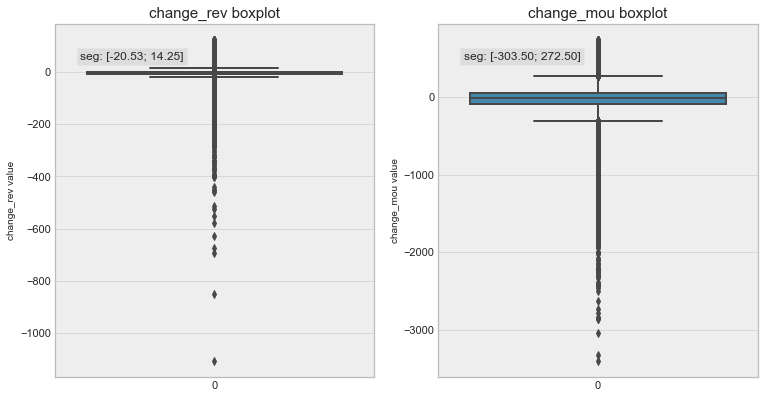

{'change_rev': [-20.5325, 14.2475], 'change_mou': [-303.5, 272.5]}

In [31]:
plot_boxplots(df_train, ['change_rev', 'change_mou'], div=2)

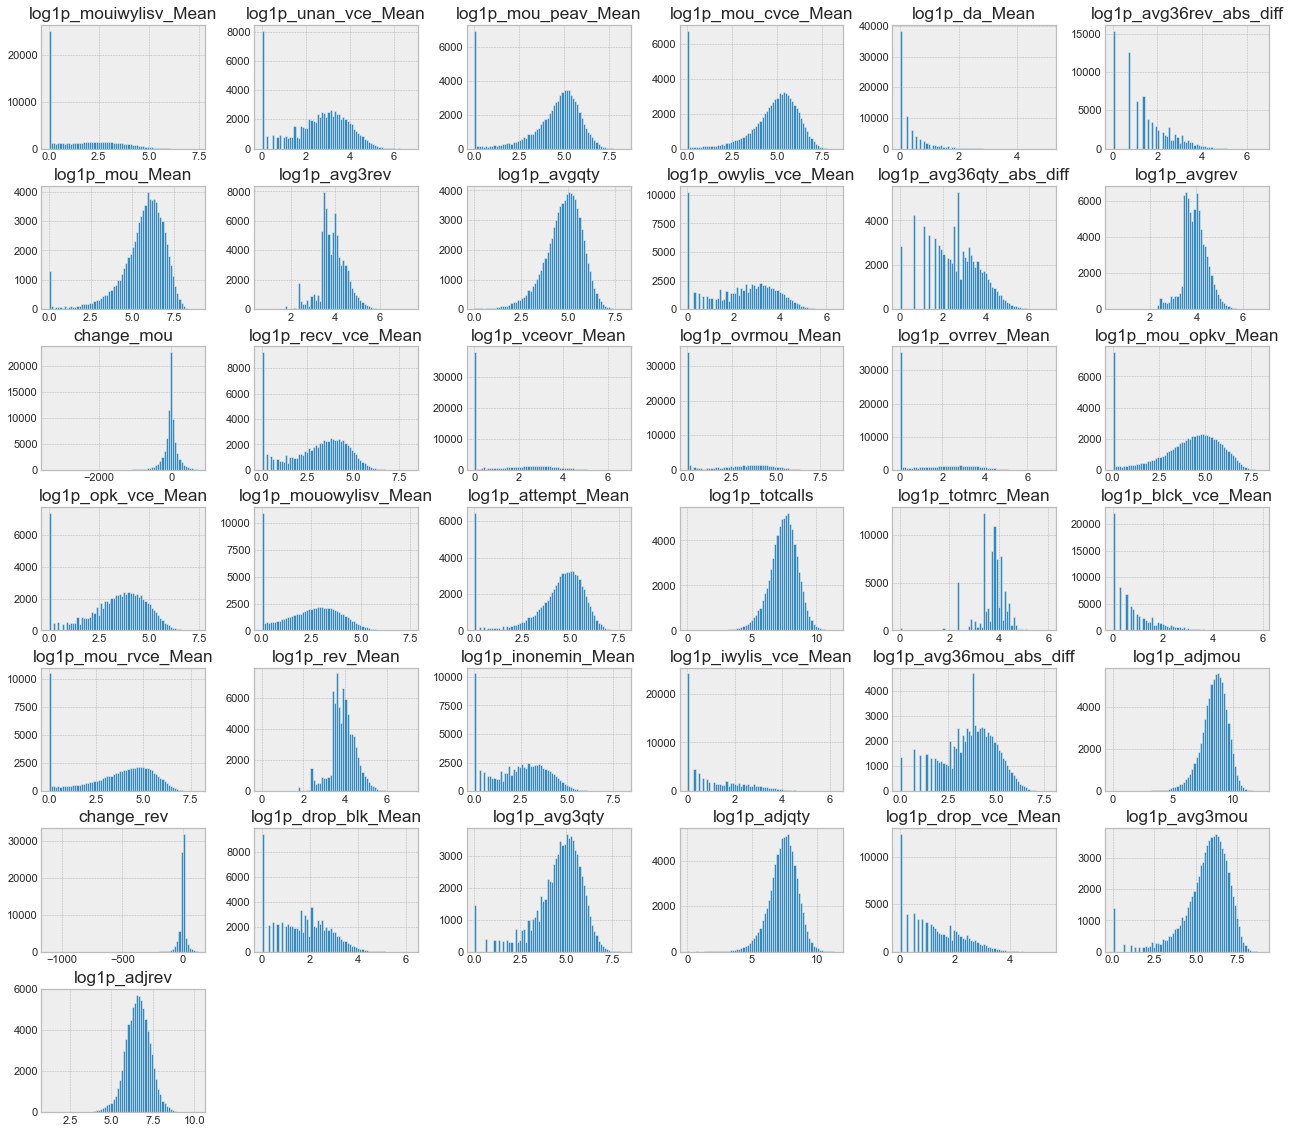

In [32]:
_ = df_train[floats].hist(bins=70, figsize=(22, 20))

На основе скорректированого размаха удалим выбросы из признаков. Отмечу, что нулевые значения тоже могут считаться выбросами, но удалять их нельзя -- потеряется слишком много данных. В признаках выборки особо нет выбросов с левой стороны, поэтому очистим слева лишь по малой квантили -- так мы сохраним нули. Нужно подобрать такое значение квантили, чтобы ушло не слишком много объектов. Коэффициент 1.5 с этой же целью тоже лучше увеличить.

In [33]:
def destroy_outliers_adjbox(df, features, coeff=1.5, q=None):
    for feature in features:
        values = df[feature]
        left, right = iqr_segment(values, _type='adjbox', coeff=coeff)

        if q is None:
            inds = df[(df[feature] > right) | (df[feature] < left)].index
        else:
            inds = df[(df[feature] > right) | (df[feature] < values.quantile(q))].index
            
        try:
            df.drop(index=inds, inplace=True)
        except:
            print('{}\'s outliers are already deleted'.format(feature))

In [34]:
destroy_outliers_adjbox(df_train, floats, coeff=1.75, q=0.0075)

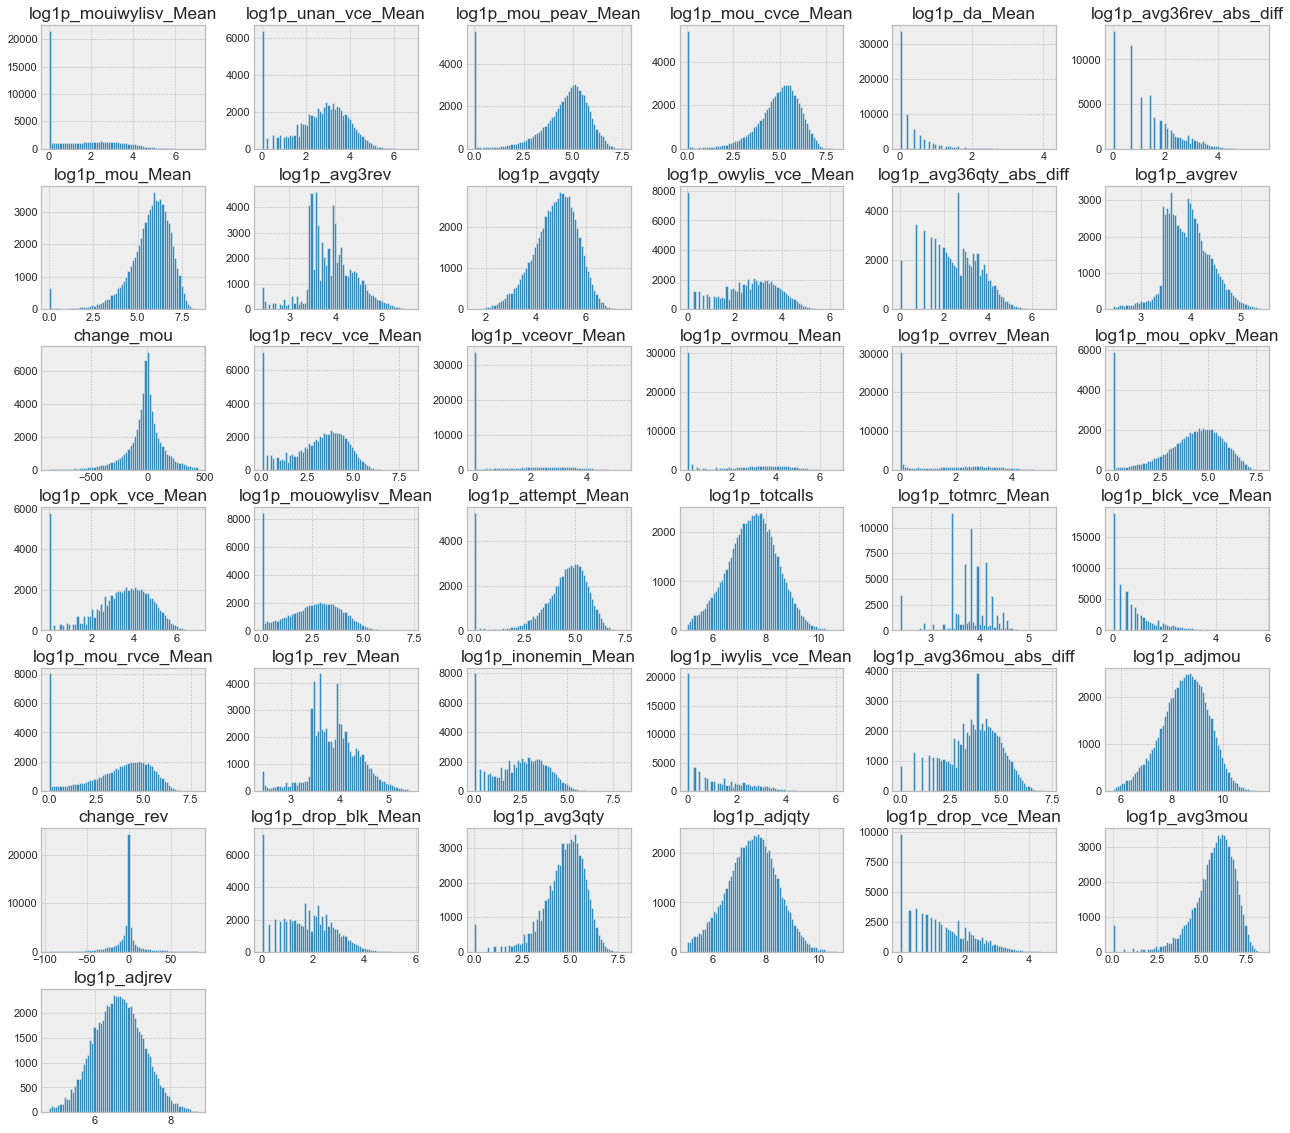

In [35]:
_ = df_train[floats].hist(bins=70, figsize=(22, 20))

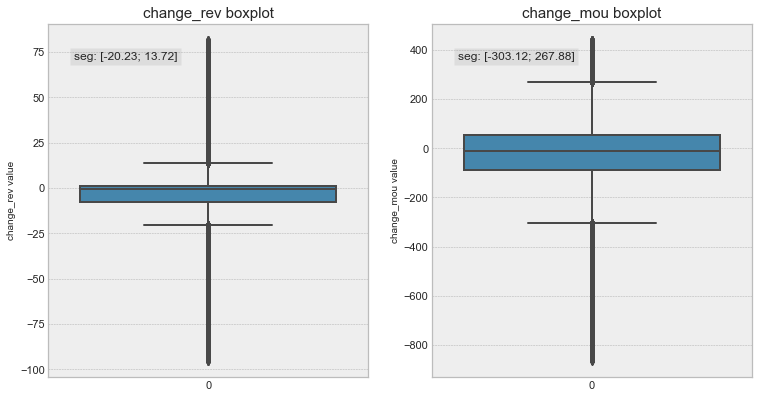

{'change_rev': [-20.231875, 13.723125], 'change_mou': [-303.125, 267.875]}

In [36]:
plot_boxplots(df_train, ['change_rev', 'change_mou'], div=2)

In [37]:
df_train.shape

(70147, 120)

Распределения стали уже намного чище, однако было удалено достаточно много объектов (порядка 8 тысяч).

Посмотрим на целочисленные признаки.

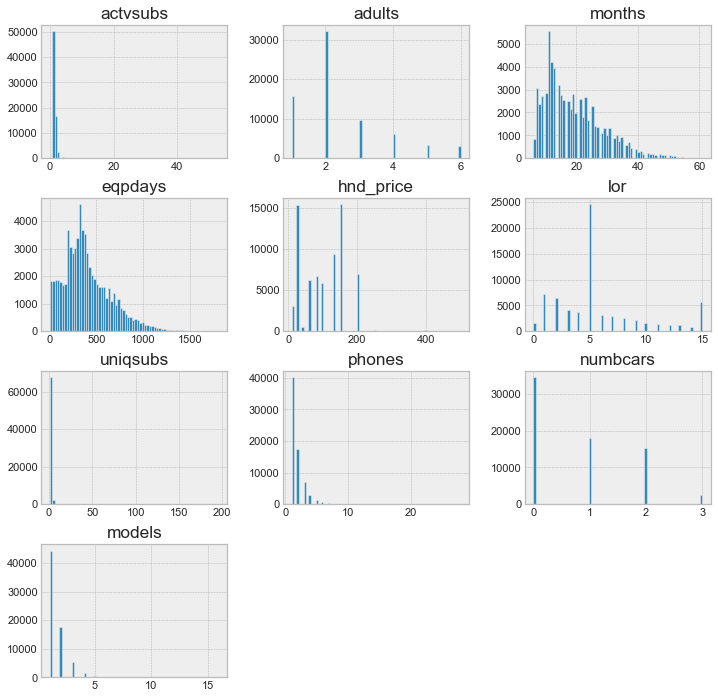

In [38]:
_ = df_train[ints].hist(bins=70, figsize=(12, 12))

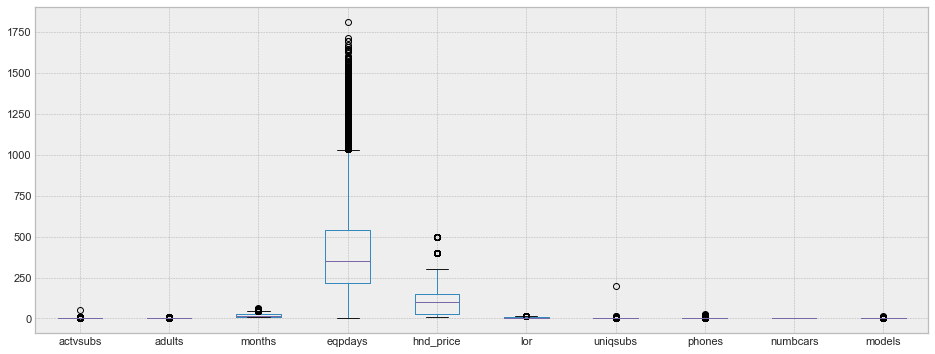

In [39]:
_ = df_train[ints].boxplot(figsize=(16, 6))

Некоторые выбросы действительно есть. Так, нам, например, следует исключить из выборки объекты с большим числом подписчиков, так как очень странно, когда к социальной сети привязано больше 5 мобильных устройств (может, следует так интерпретировать этот признак?). Такие пользователи сильно выделяются из общей массы и могут испортить модель.

In [40]:
df_train.drop(df_train[df_train.phones > 10].index, inplace=True)
df_train.drop(df_train[df_train.models > 10].index, inplace=True)
df_train.drop(df_train[df_train.uniqsubs > 50].index, inplace=True)
df_train.drop(df_train[df_train.actvsubs > 20].index, inplace=True)
df_train.drop(df_train[df_train.eqpdays > 1300].index, inplace=True)

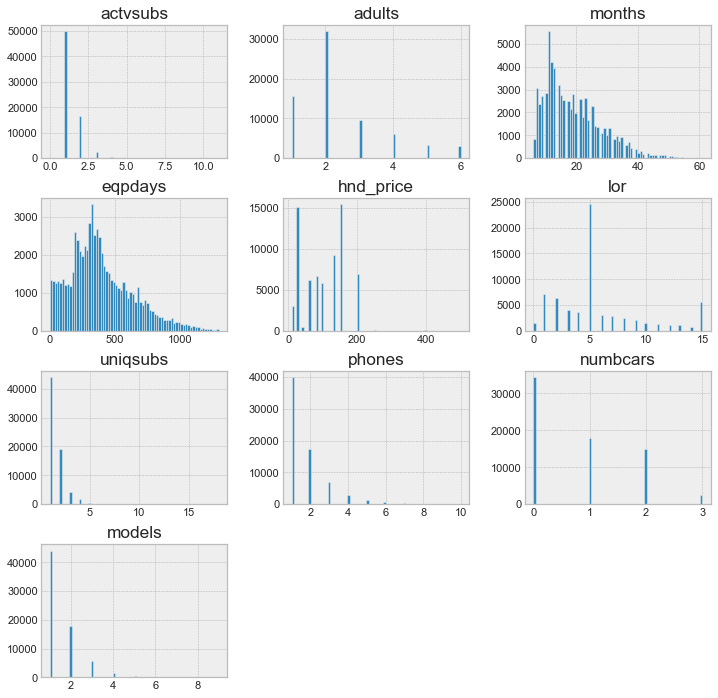

In [41]:
_ = df_train[ints].hist(bins=70, figsize=(12, 12))

In [42]:
df_train.shape

(69809, 120)

## Модельный подход

Принцип модельного подхода сводится к детекции аномалий. Можно применять модели [одноклассовой классификации](https://github.com/esokolov/ml-course-hse/blob/master/2020-spring/lecture-notes/lecture16-anomaly.pdf), такие как `One-Class SVM`, `Local Outlier Factor`, `(Extended) Isolation Forest`. Если бы наша задача была сильно несбалансированой (мало объектов оттока), то такие модели можно было бы применять для ее решения, используя особые метрики.

Для детекции выбросов в признаковом пространстве я буду использоваться `Isolation Forest` из `sklearn` (хотел бы использовать оригинальную расширенную версию авторов статьи, но она не устанавливается).

In [43]:
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html
X = df_train[floats | ints].to_numpy()
iso = IsolationForest(n_estimators=150, max_samples=13500, random_state=SEED, n_jobs=-1).fit(X)
nonout_inds = iso.predict(X)
outliers = np.squeeze(np.argwhere(nonout_inds == -1))
len(outliers)

1229

Модель нашла аномальные объекты. Здесь важно грамотно подобрать гиперпараметры, так как от них зависит, например, число аномальных объектов.

Я не буду удалять эти объекты, так как уже было удалено достаточно много данных. Отмечу, что в целом такой подход позволяет бизнесу проводить анализ аномальных данных. Например, можно исследовать распределения.

In [44]:
df_out = df_train.iloc[outliers]

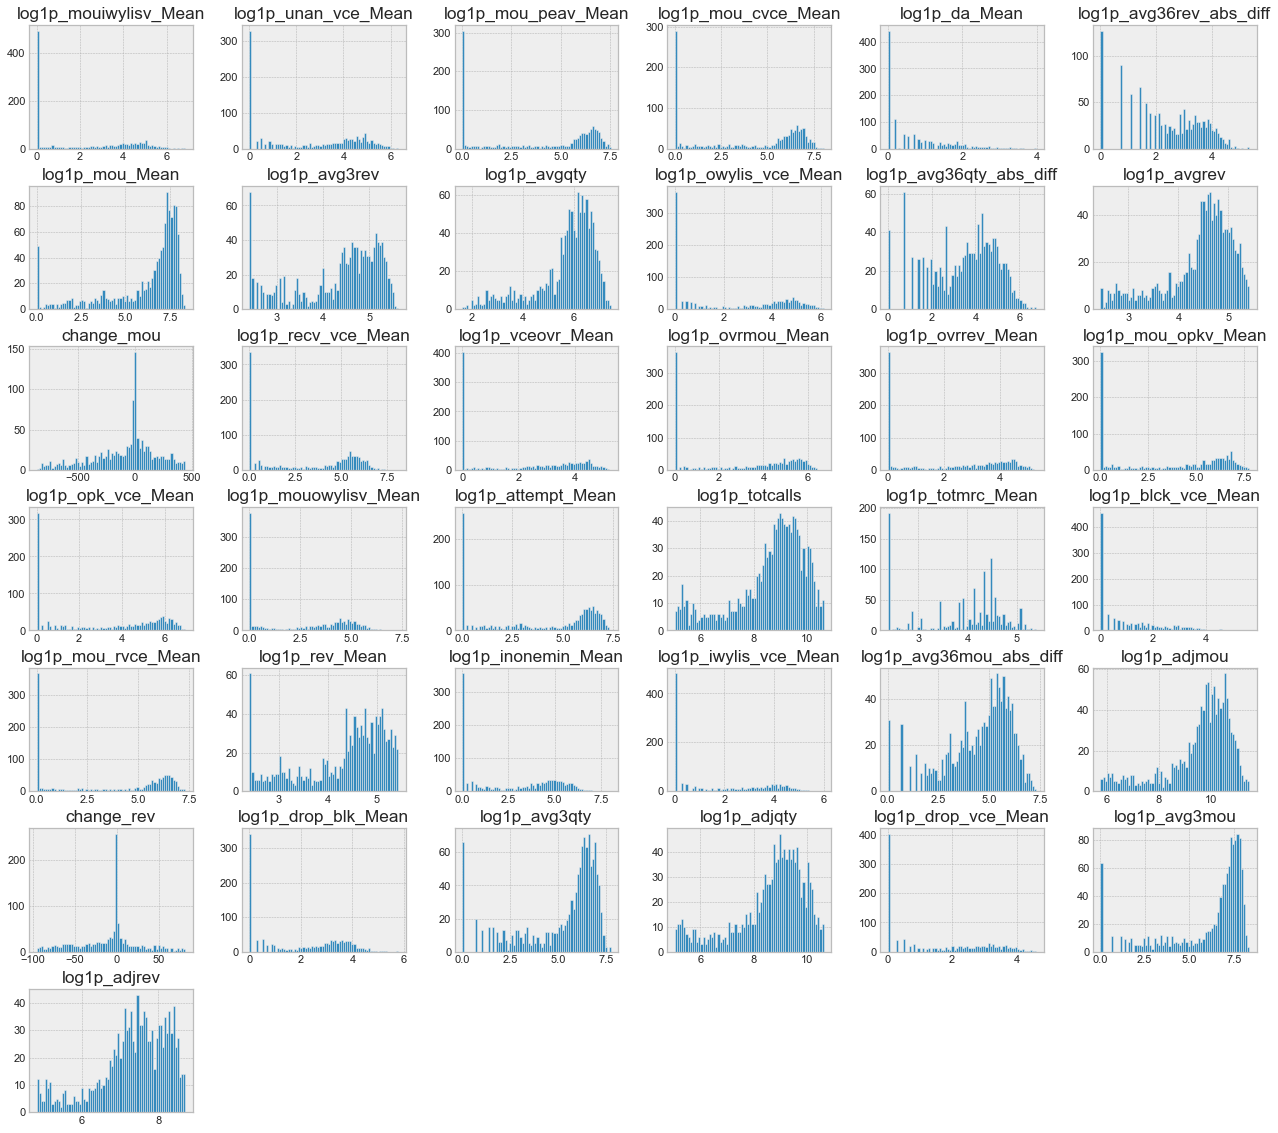

In [45]:
_ = df_out[floats].hist(bins=70, figsize=(22, 20))

In [46]:
assert df_train.shape[1] == len(floats) + len(ints) + len(binary) + len(cats) + len(indicators) + 1
df_train.shape[1]

120

In [47]:
features_dict = {
    'float': list(floats),
    'int': list(ints),
    'binary': list(binary),
    'categorical': list(cats),
    'nan_indicators': list(indicators),
    'target': 'churn',
}

In [48]:
try:
    os.mkdir('data_cleaned')
except:
    pass

df_train.to_csv('data_cleaned/df.csv', index=False)
df_test.to_csv('data_cleaned/df_test.csv', index=False)

jsonStr = json.dumps(features_dict)
file = open('features_types_cleaned.json', 'w')
file.write(jsonStr)
file.close()